In [3]:
import pandas as pd 
from scipy import stats   
import numpy as np 
import timeit
from tabulate import tabulate
import inspect

In [4]:
class good_df:
    
    def __init__(self,df):
    
        self.text_path='output/output.txt'
        self.csv_path='output/goodDF.csv'

        # create instance vars
        self.num_cols = self.cata_df(df) # figure out numeric columns
        self.df,self.invalid_index =self.remove_invalid(df)
        

    def remove_invalid(self,df):

        '''takes in df and removes all 0,nan,inf values
        input=df
        output=filtered df'''

        invalid_index = [df.index[(df[column]==0) |(df[column].isnull())|(df[column] == np.inf)].tolist() for column in self.num_cols]
        invalid_index = [item for sublist in invalid_index for item in sublist] # flatten array
        invalid_index=list(set(invalid_index)) # delete duplicates 
        df.drop(invalid_index,inplace=True)
        df.reset_index(inplace=True,drop=True)
        print('Shape of df after invalid removal =', df.shape)

        return df,invalid_index

    def cata_df(self,df):

        num_cols= df.select_dtypes(include=[np.number]).columns

        return num_cols


    def remove_extrema(self):

        ''' removes outliers from given df
        input = df
        output = index of extreme values, new df'''

        df=self.df
        z_df=np.abs(df[self.num_cols].apply(stats.zscore))
        extrema_index = [z_df.index[z_df[column]>3].tolist() for column in z_df.columns] #nxm, m=len(num_cols)

        # writing to file
        table=pd.DataFrame(columns=['column','z-score','outlier','value']) # pretty write
        for col_idx,col in enumerate(self.num_cols):
            #print('col_idx = {}, col = {}'.format(col_idx,col))
            for idx in extrema_index[col_idx]: #pick extrema index for n column
                table = table.append({\
                'column' : col\
                ,'z-score' : z_df.loc[idx,col]\
                ,'outlier':df.loc[idx,'title']\
                ,'value':df.loc[idx,col]} , ignore_index=True)
        
        # creating new df
        extrema_index = list(set([item for sublist in extrema_index for item in sublist])) #unfurl list, flatten list
        df.drop(extrema_index,inplace=True)
        df.reset_index(drop=True,inplace=True) 

        #write table and some df properties
        with open(self.text_path,'w+') as file:
            file.write('\n Table with all outliers: \n')
            file.write(tabulate(table, headers='keys',numalign="right",tablefmt="fancy_grid"))
            file.write('\n \n Statistical properties of data (after): \n {0} '.format(df.describe()))
        print('Final shape = ',df.shape)

        # changing aspect ratio
        if 'aspect ratio' in df.columns:
            df['aspect ratio'] = [df.loc[s,'aspect ratio'].split(':',1)[0] for s in range(len(df))]
        
        df.to_csv(self.csv_path,index=False)
        return df,extrema_index
    
    def get_ROI(self,sales,cost,case='sort'):

        '''gets the ROI for all and puts in the df passed in 
        inputs = sales, cost, array-like
        output = df with new ROI column '''

        df=self.df
        df['ROI']=((df[sales]-df[cost])/df[cost])*100
        df,_=self.remove_invalid(df)

        if case == 'sort':
            df.sort_values(by='ROI',ascending=False,inplace=True)
            df.to_csv('output/highest_ROI.csv')
        return df


    def popularity(self):
        pass

In [5]:
df=pd.read_csv("/Users/austinbenny/Documents/python/movie_budget_ratings/IMDB_data/imdb_data_final_v2.csv")

movies=good_df(df)


Shape of df after invalid removal = (2067, 8)


In [11]:
from plotting import master_plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


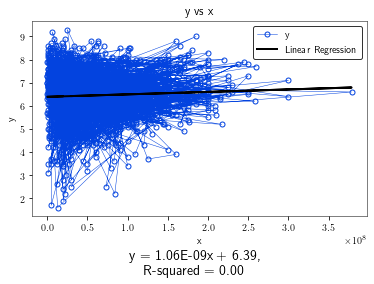

In [12]:
master_plot(df.loc[:,'Budget'],df.loc[:,'rating'],trendline=True)